In [65]:
# import the packages needed for plotting
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os, json

In [66]:
colors_light = {
    'NF54': '#829AA3',
    'Heparin 50':'#829AA3',
    
    '3D7':'#B9BDC5',
    '3D7 (viola)': '#B9BDC5',

    'KOP230P': '#91b1be',
    'KOPfs25': '#9fc9d9',

    'KOEBA140': '#DAEBC6',
    'KOEBA181': '#84B06D',
    'KOEBA175': '#C1E2D4',
    'KOEBA175+Anti-GYPA':'#A5D0D4',
    'KORH1': '#F9DA9A',
    'KORH4': '#F3A59B',
    'KORh2a': '#F7CAA1',
    'KORH2a': '#F7CAA1',

    

    'Barseq': '#BEBFBC',

    'cKOMSP1 DMSO':'#B9BDC5',
    'cKOMSP1 Rap':'#FFE3B8',

    'Neuraminidase':'#D6EE96',
    
    'Anti-CD55':'#97B6DA',
    'Anti-GYPA':'#B6E2DF',
    'R1':'#F1AAD1',
    'Anti-GYPC':'#93E1DB',
    'Anti-CR1 ab25':'#DEAC7F',
    'Anti-CR1 ABIN':'#DEAC7F',

    'Anti-Basigin':'#C6C5D3',
    
    'cKOGAP45 DMSO': '#B9BDC5',
    'cKOGAP45 Rap': '#E5486C',

    'cKOAMA1 DMSO':'#B9BDC5',
    'cKOAMA1 Rap':'#EBD1D9',
    
 
}

colors_dark = {
    'NF54': '#043546',
    'Heparin 50':'#818897',

    '3D7':'#818897',
    '3D7 (viola)': '#818897',

    'KOP230P': '#406a7d',
    'KOPfs25': '#78a3b9',

    'KOEBA140': '#9ECA69',
    'KOEBA181': '#486737',
    'KOEBA175': '#6AB997',
    'KOEBA175+Anti-GYPA':'#04A0AF',
    'KORH1': '#F1AF23',
    'KORH4': '#E8513E',
    'KORh2a': '#ED8626',
    'KORH2a': '#ED8626',


    'Barseq': '#BEBFBC',

    'cKOMSP1 DMSO':'#FFD086',
    'cKOMSP1 Rap':'#FFD086',

    'Neuraminidase':'#ABDC29',
    
    'Anti-CD55':'#97B6DA',
    'Anti-GYPA':'#91D4CF',
    'R1':'#E459A5',
    'Anti-GYPC':'#35BEB4',
    'Anti-CR1 ab25':'#C6545E',
    'Anti-CR1 ABIN':'#C6545E',

    'Anti-Basigin':'#7E7C9C',
   
    
  
    'cKOGAP45 DMSO': '#81132C',
    'cKOGAP45 Rap': '#81132C',

    
    'cKOAMA1 DMSO':'#CC889D',
    'cKOAMA1 Rap':'#CC889D',
}

In [67]:
SELECTED_INDEX = 0

experiment_files = [f for f in os.listdir() if 'EEJR' in f]
f = experiment_files[SELECTED_INDEX]

print('All experiment files:', experiment_files)
print("Selected file", f, "at index", SELECTED_INDEX)


with open(f, 'r') as json_file:
    data = json.load(json_file)
MM_actions = data['MM_actions']
S_actions = data['S_actions']
S_type = data['S_type']
S_location = data['S_location']
MM_location = data['MM_location']
cq_file = data['cq_file']

All experiment files: ['EEJR0156.json', 'EEJR0157.json', 'EEJR0158.json', 'EEJR0159.json', 'EEJR0160.json', 'EEJR0161.json', 'EEJR0162.json']
Selected file EEJR0156.json at index 0


In [68]:
# This links the names of the wells to the master mixes that were placed in them
master_mix_mapping = { destination_well: MM_location[source_well] for source_well, destination_wells in MM_actions.items() for destination_well in destination_wells }

# This links the names of the wells to the samples that were placed in them
sample_mapping = { destination_well: S_location[source_well] for source_well, destination_wells in S_actions.items() for destination_well in destination_wells }

# This links the names of the wells to the samples type that were placed in them
type_mapping = { destination_well: S_type[source_well[0]] for source_well, destination_wells in S_actions.items() for destination_well in destination_wells }

In [69]:
# opens the file with the data in it and selects the columns with the relavent information in it
df_full = pd.read_excel(cq_file)

df = pd.DataFrame(df_full[['Well', 'Cq']])
#This reformates the well names to remove the 0 so they match the formate of the lists above 
df['Well'] = df['Well'].str[0] + df['Well'].str[1:].astype(str).str.lstrip('0')

# This adds columes for the master mix, type and sample 
df['gene'] = df['Well'].map(master_mix_mapping)
df['type'] = df['Well'].map(type_mapping)
df['sample'] = df['Well'].map(sample_mapping)

Removed 0 outliers from AMA1


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


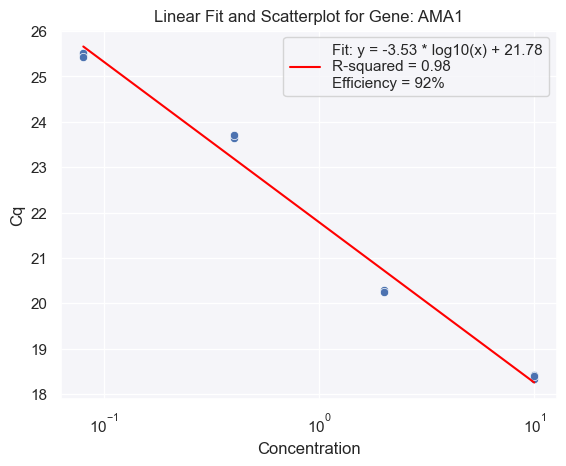

Removed 0 outliers from Actin1


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


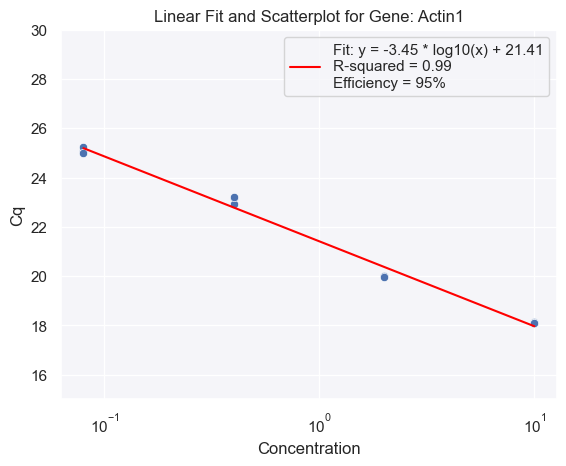

Removed 0 outliers from EBA140


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


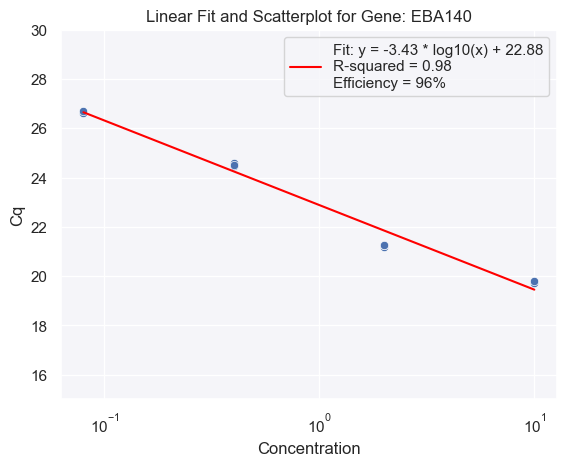

Removed 0 outliers from EBA165


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


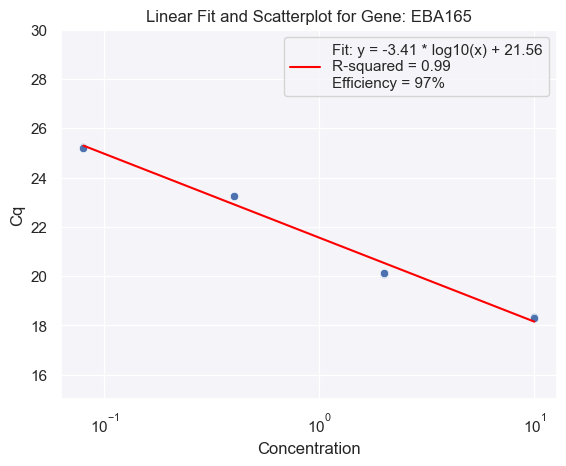

Removed 0 outliers from EBA175


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


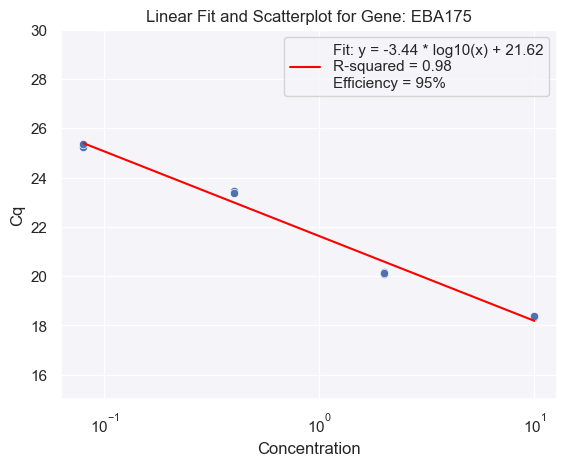

Removed 0 outliers from EBA181


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


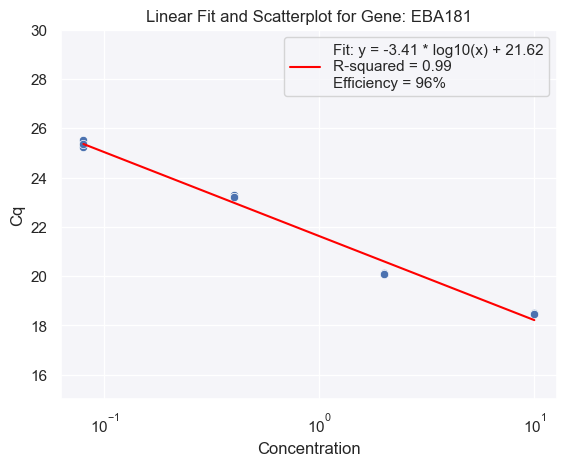

Removed 0 outliers from Pfcyp87


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


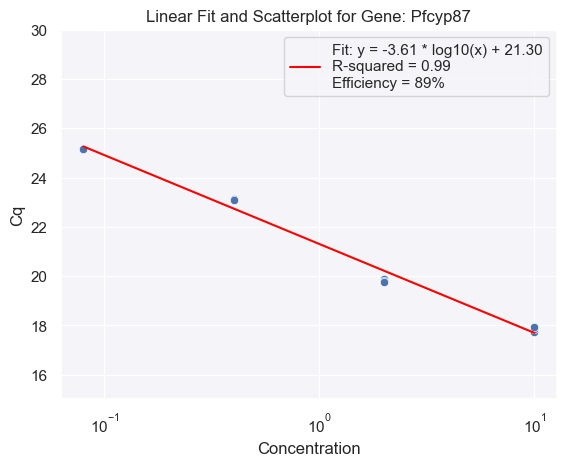

Removed 0 outliers from RH1


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


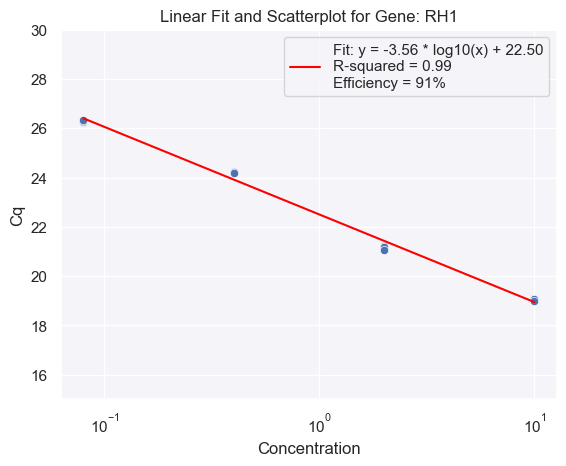

Removed 0 outliers from RH2a


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


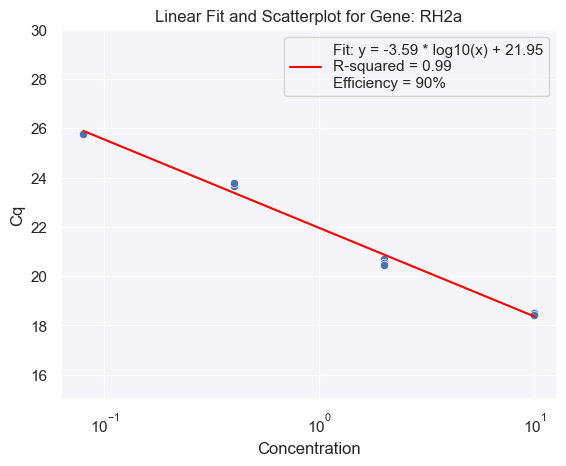

Removed 0 outliers from RH2b


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


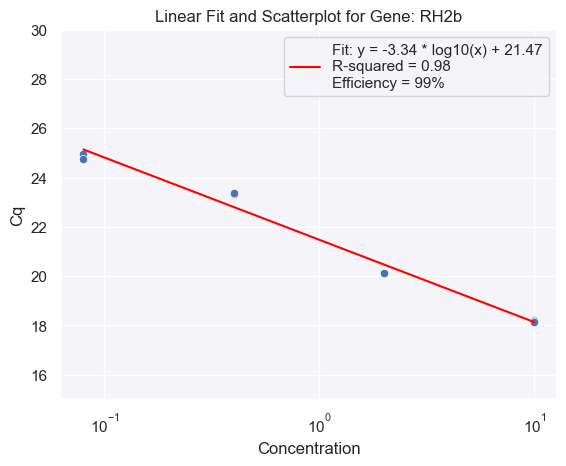

Removed 0 outliers from RH3


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


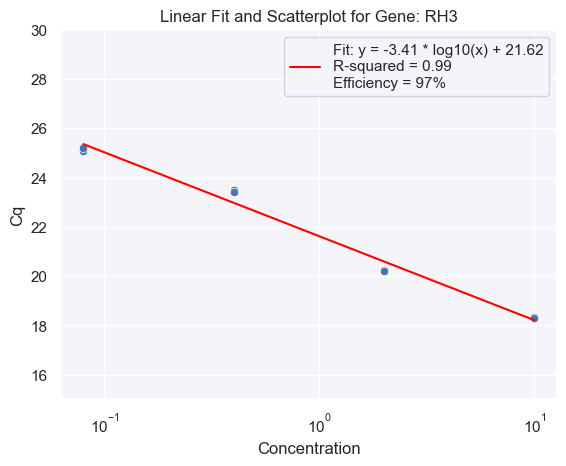

Removed 0 outliers from RH4


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


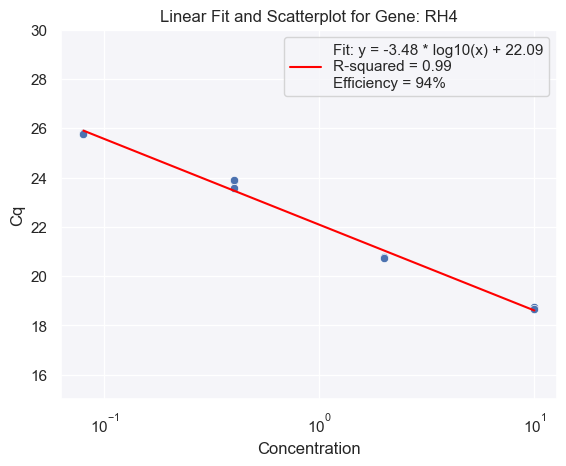

Removed 1 outliers from RH5


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


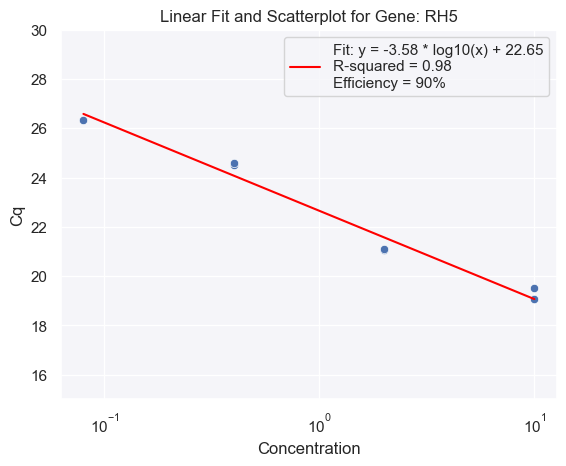

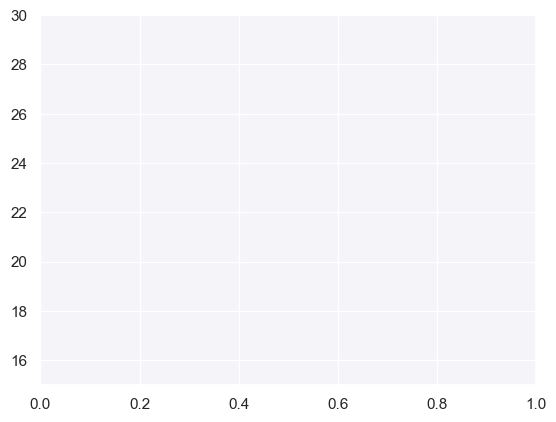

In [70]:
sns.set_theme(context='notebook', 
              style='darkgrid', 
              #font='Candara', 
              font_scale=1, 
              color_codes=True, 
              rc=None)
sns.set_style(rc = {'axes.facecolor': '#F5F5F9'})

# Plot standards
dfq = df.query('type == "standard"')

# for gene, dfg in dfq.groupby('gene'):
#     print(dfg)
#     dfg = pd.DataFrame(dfg)
#     dfg['sample'] = dfg['sample'].astype(float)
#     sns.scatterplot(data=dfg, x='sample', y='Cq')
#     plt.xlabel('Concentration')
#     plt.xscale('log')
#     break

standard_results = {}

def efficiency_for_slope(slope):
    E = 10**(-1/slope)
    return (E - 1) * 100

def remove_outliers(df, threshold=6):
    df['mean_Cq'] = df.groupby('sample')['Cq'].transform('mean')
    df['is_outlier'] = abs(df['Cq'] - df['mean_Cq']) > threshold
    return df

for gene, dfg in dfq.groupby('gene'):
    dfg = pd.DataFrame(dfg)
    dfg['sample'] = dfg['sample'].astype(float)

    dfg = remove_outliers(dfg)
    print(f'Removed {len(dfg.loc[dfg["is_outlier"]].index)} outliers from {gene}')
    dfg = dfg.loc[~dfg['is_outlier']]

    # Scatter plot
    sns.scatterplot(data=dfg, x='sample', y='Cq')
    
    # Calculate linear fit coefficients using log base 10
    fit_coefficients = np.polyfit(np.log10(dfg['sample']), dfg['Cq'], 1)
    slope = fit_coefficients[0]
    intercept = fit_coefficients[1]
    
    # Create the fit line
    fit_line = np.polyval(fit_coefficients, np.log10(dfg['sample']))
    
    # Calculate R-squared
    correlation_matrix = np.corrcoef(np.log10(dfg['sample']), dfg['Cq'])
    r_squared = correlation_matrix[0, 1] ** 2
    
    # compute efficiency
    efficiency = efficiency_for_slope(slope)

    label = f'Fit: y = {slope:.2f} * log10(x) + {intercept:.2f}\nR-squared = {r_squared:.2f}\nEfficiency = {efficiency:.0f}%'
    standard_results[gene] = {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_squared,
        'efficiency': efficiency,
    }
    # Add the fit line and R-squared to the plot
    plt.plot(dfg['sample'], fit_line, color='red', label=label)
    
    plt.xlabel('Concentration')
    plt.xscale('log')  # Set x-axis to log scale
    plt.ylabel('Cq')
    plt.title(f'Linear Fit and Scatterplot for Gene: {gene}')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.ylim((15,30))
    #sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

    # break  # Remove this if you want to loop through all genes

In [71]:
pd.DataFrame(standard_results)

,AMA1,Actin1,EBA140,EBA165,EBA175,EBA181,Pfcyp87,RH1,RH2a,RH2b,RH3,RH4,RH5
slope,-3.532486,-3.447464,-3.433494,-3.407149,-3.438614,-3.409096,-3.607943,-3.556298,-3.590603,-3.341579,-3.407090,-3.480982,-3.584091
intercept,21.784695,21.412109,22.883615,21.559094,21.623358,21.622586,21.303655,22.502125,21.953868,21.474214,21.618126,22.086414,22.651038
r_squared,0.983833,0.989526,0.981059,0.988592,0.984645,0.986031,0.989906,0.994074,0.992118,0.982041,0.985219,0.992870,0.978211
efficiency,91.905213,95.015136,95.545825,96.562440,95.350640,96.486563,89.306807,91.069454,89.891150,99.186409,96.564730,93.764976,90.112543


In [72]:
dfq = df.query('type == "Negative control"')
print(dfq['Cq'])

364          NaN
365          NaN
366    34.043115
367          NaN
368          NaN
369          NaN
370          NaN
371          NaN
372          NaN
373          NaN
374          NaN
375          NaN
376          NaN
Name: Cq, dtype: float64


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

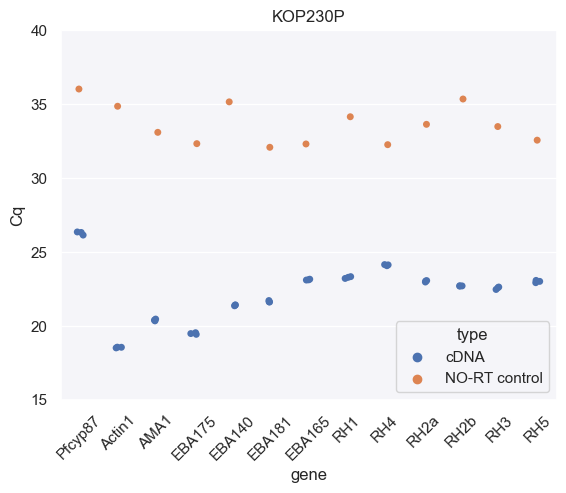

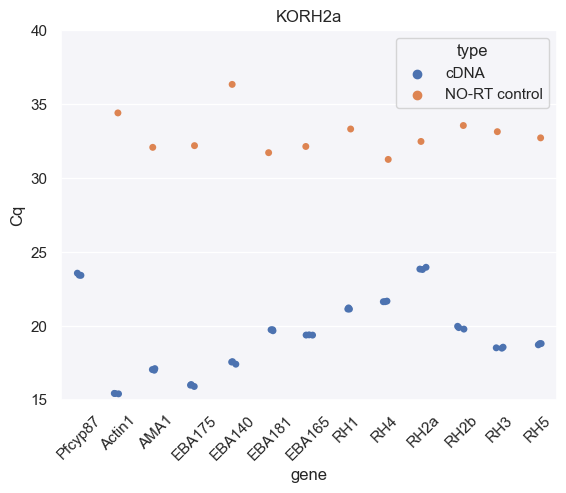

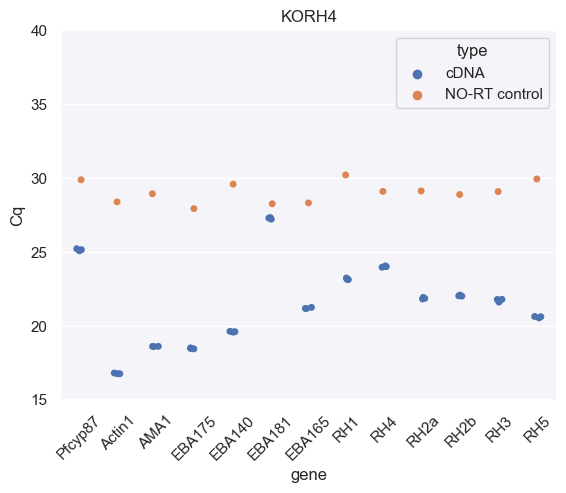

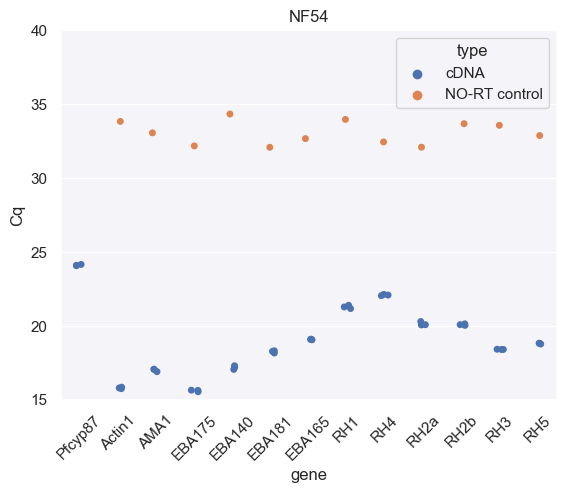

In [73]:
dfq = df.query('type == ["cDNA", "NO-RT control"]')

samples = dfq['sample'].unique()
genes = dfq['gene'].unique()

for sample, dfg in dfq.groupby('sample'): 
    plt.figure()
    sns.stripplot(
        data=dfg,
        x='gene',
        y='Cq',
        hue='type',
    )
    plt.title(sample)
    plt.xticks(rotation=45)
    plt.ylim((15,40))

In [74]:
df_cdna_replicates = pd.DataFrame(df.query('type == "cDNA"'))


# compute ceoncentration from Cq
for gene, dfg in df_cdna_replicates.groupby('gene'):
    standard_result = standard_results[gene]
    slope = standard_result['slope']
    intercept = standard_result['intercept']
    # print(gene, slope, intercept, len(dfg.index))

    df_cdna_replicates.loc[dfg.index, 'relative_concentration'] = 10 ** ((dfg['Cq'] - intercept) / slope)

# compute mean and std for each combination of gene and sample
df_cdna = df_cdna_replicates.groupby(['gene', 'sample'], as_index=False).agg(
    gene=('gene', 'first'),
    sample=('sample', 'first'),
    mean_relative_concentration=('relative_concentration', 'mean'),
    std_relative_concentration=('relative_concentration', 'std'),
)

# normalize by housekeeping genes
for sample, dfg in df_cdna.groupby('sample'):
    actin_concentration = float(dfg.query('gene == "Actin1"')['mean_relative_concentration'].iloc[0]) # should be just one before iloc[0]
    df_cdna.loc[dfg.index, 'Normalized relative concentration (Actin1)'] = dfg['mean_relative_concentration'] / actin_concentration
    
    pfcyp_concentration = float(dfg.query('gene == "Pfcyp87"')['mean_relative_concentration'].iloc[0]) # should be just one before iloc[0]
    df_cdna.loc[dfg.index, 'Normalized relative concentration (Pfcyp87)'] = dfg['mean_relative_concentration'] / pfcyp_concentration

    pfcyp_concentration = float(dfg.query('gene == "AMA1"')['mean_relative_concentration'].iloc[0]) # should be just one before iloc[0]
    df_cdna.loc[dfg.index, 'Normalized relative concentration (AMA1)'] = dfg['mean_relative_concentration'] / pfcyp_concentration


# relative difference compared to NF54 (WT)
for gene, dfg in df_cdna.groupby('gene'):
    nf_concentration = float(dfg.query('sample == "NF54"')['Normalized relative concentration (Actin1)'].iloc[0])
    df_cdna.loc[dfg.index, 'Expression fold change to NF54 (normalised to Actin1)'] = dfg['Normalized relative concentration (Actin1)'] / nf_concentration
    
    nf_concentration = float(dfg.query('sample == "NF54"')['Normalized relative concentration (Pfcyp87)'].iloc[0])
    df_cdna.loc[dfg.index, 'Expression fold change to NF54 (normalised to Pfcyp87)'] = dfg['Normalized relative concentration (Pfcyp87)'] / nf_concentration

    nf_concentration = float(dfg.query('sample == "NF54"')['Normalized relative concentration (AMA1)'].iloc[0])
    df_cdna.loc[dfg.index, 'Expression fold change to NF54 (normalised to AMA1)'] = dfg['Normalized relative concentration (Pfcyp87)'] / nf_concentration

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_cdna

,gene,sample,mean_relative_concentration,std_relative_concentration,Normalized relative concentration (Actin1),Normalized relative concentration (Pfcyp87),Normalized relative concentration (AMA1),Expression fold change to NF54 (normalised to Actin1),Expression fold change to NF54 (normalised to Pfcyp87),Expression fold change to NF54 (normalised to AMA1)
0,AMA1,KOP230P,2.487493,0.098310,0.363432,58.802362,1.000000,0.683780,0.435799,58.802362
1,AMA1,KORH2a,22.011258,0.779183,0.399933,87.180127,1.000000,0.752454,0.646113,87.180127
2,AMA1,KORH4,7.974967,0.048201,0.359094,92.295883,1.000000,0.675617,0.684028,92.295883
3,AMA1,NF54,22.669395,1.374613,0.531505,134.930054,1.000000,1.000000,1.000000,134.930054
4,Actin1,KOP230P,6.844446,0.122701,1.000000,161.797248,2.751543,1.000000,0.637338,85.996061
5,Actin1,KORH2a,55.037340,0.598247,1.000000,217.986740,2.500418,1.000000,0.858675,115.861063
6,Actin1,KORH4,22.208593,0.390712,1.000000,257.024474,2.784788,1.000000,1.012449,136.609818
7,Actin1,NF54,42.651322,1.424727,1.000000,253.864083,1.881450,1.000000,1.000000,134.930054
8,EBA140,KOP230P,2.732563,0.056510,0.399238,64.595608,1.098521,0.370783,0.236314,31.885913
9,EBA140,KORH2a,36.908703,2.312064,0.670612,146.184534,1.676810,0.622816,0.534797,72.160128


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

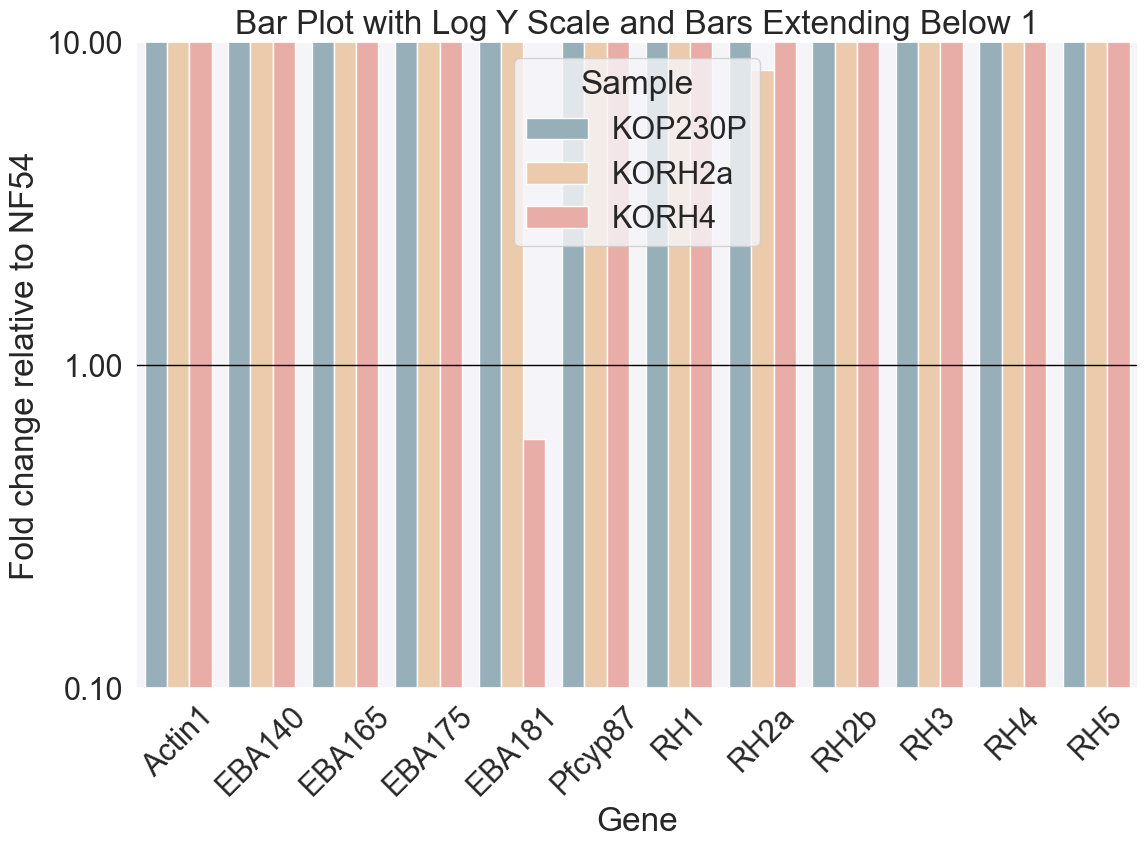

c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

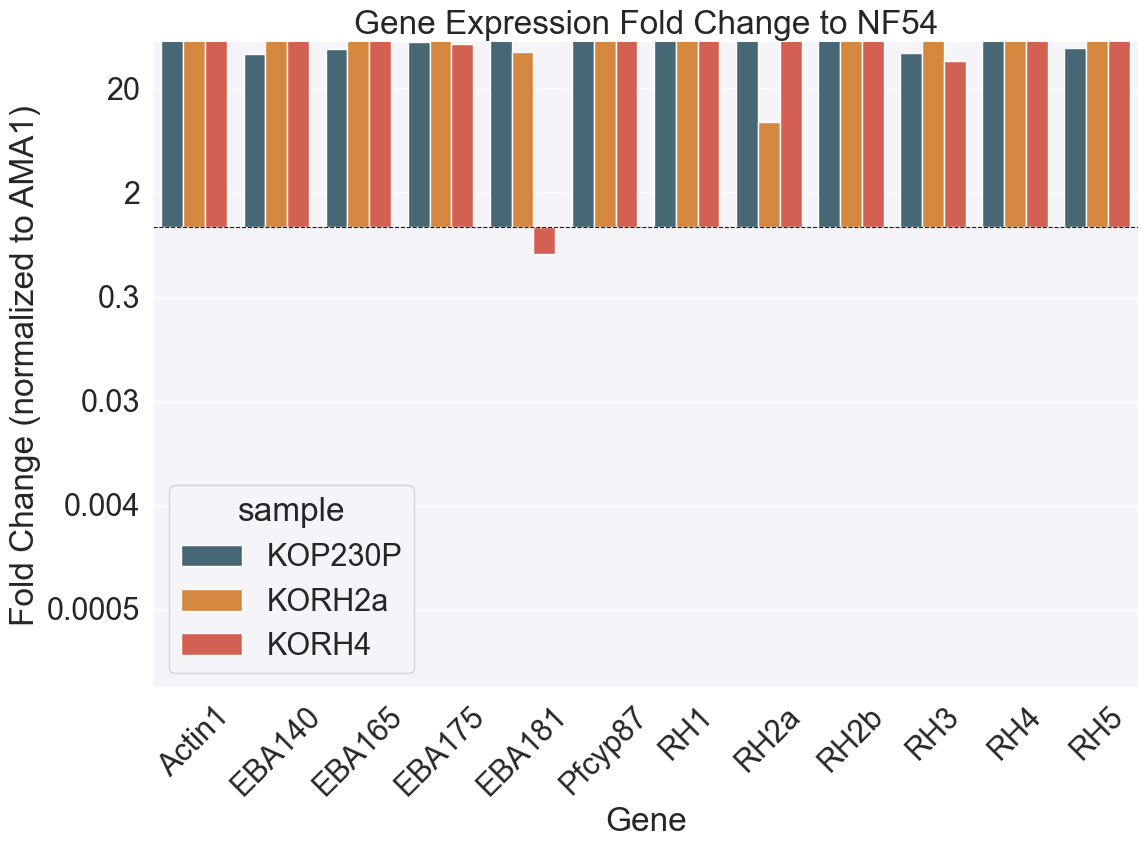

In [75]:
import matplotlib.ticker as tick
import sigfig
from matplotlib.ticker import ScalarFormatter

#df_cdna_q = df_cdna.query('sample != "NF54" and gene != "Actin1"')
df_cdna_q = df_cdna.query('sample != "NF54" and gene != "AMA1"')
#df_cdna_q = df_cdna.query('sample != "NF54" and gene != "Pfcyp87"')

plt.figure()

plt.gcf().set_size_inches(12,9)

sns.set_theme(context='notebook', 
              style='darkgrid', 
              #font='Candara', 
              font_scale=2, 
              color_codes=True, 
              rc=None)
sns.set_style(rc = {'axes.facecolor': '#F5F5F9'})

sns.barplot(
    data=df_cdna_q,
    x='gene',
    #y='Expression fold change to NF54 (normalised to Actin1)',
    y='Expression fold change to NF54 (normalised to AMA1)',
    #y='Expression fold change to NF54 (normalised to Pfcyp87)',
    hue='sample',
    palette=colors_light, 
)

plt.yscale('log')
plt.ylim([0.1, 10])  # Set y-axis limits to extend below and above the baseline
plt.axhline(y=1, color='black', linewidth=1)  # Add a horizontal line at y=1

plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

plt.xlabel('Gene')
plt.ylabel('Fold change relative to NF54')
plt.title('Bar Plot with Log Y Scale and Bars Extending Below 1')

plt.legend(title='Sample')
plt.tight_layout()  # Adjust layout to prevent cropping of labels
plt.show()

def make_plot(df, x_key, y_key, hue_key):

    plt.gcf().set_size_inches(12,9)
    ax = sns.barplot(y=df[y_key]-1, x=df[x_key], hue=df[hue_key], bottom=1, palette=colors_dark)
    ax.axhline(y=1, c='k', linestyle='--', lw=0.8) # Make the line dashed and thinner

    plt.yscale('log', base=2)
    # Improved y-tick formatting
    #major_ticks = np.append(np.arange(0.01, 0.8, 0.01), np.arange(1, 2, 0.1))
    #minor_ticks = np.arange(0.3, 1, 0.1)
    #ax.set_yticks(major_ticks)
    #ax.set_yticks(minor_ticks, minor=True)
    #ax.yaxis.set_major_formatter(lambda x, pos: f'{x:.0f}' if x >= 1 else f'{x:.1f}')

    ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, y: sigfig.round(x, sigfigs=1, type=str)))
    plt.xticks(rotation=45)
    plt.ylim((0.0001,40))

    # Remove the outline of the plot
    sns.despine()

    # Add title and labels for clarity
    ax.set_title("Gene Expression Fold Change to NF54")
    ax.set_xlabel("Gene")
    #ax.set_ylabel("Fold Change (normalized to Actin1)")
    ax.set_ylabel("Fold Change (normalized to AMA1)")
    #ax.set_ylabel("Fold Change (normalized to Pfcyp87)")
     

    plt.tight_layout()
    plt.show()


make_plot(
    df=df_cdna_q,
    x_key='gene',
    #y_key='Expression fold change to NF54 (normalised to Actin1)',
    y_key='Expression fold change to NF54 (normalised to AMA1)',
    #y_key='Expression fold change to NF54 (normalised to Pfcyp87)',
    hue_key='sample',
)